In [39]:
import os
import shutil
import pandas as pd
import numpy as np
import re
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten
from time import time
import itertools
from sklearn.metrics import confusion_matrix
%matplotlib inline
%config Completer.use_jedi = False
import visualkeras

# Partitioning the dataset

In [4]:
input_path = r'/jet/home/mhrahman/Projects/HW1/HW1/Classification/'
output = r'/jet/home/mhrahman/Projects/HW1/Output/'

if len(os.listdir(output))!= 3:
    splitfolders.ratio(input=input_path,output=output, seed= 69, ratio=(.6,.2,.2),group_prefix=None)
else:
    pass

# Process the dataset 

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
training_dir = r'/jet/home/mhrahman/Projects/HW1/Output/train/'
val_dir = r'/jet/home/mhrahman/Projects/HW1/Output/val/'
test_dir =r'/jet/home/mhrahman/Projects/HW1/Output/test/'

train_datagen = ImageDataGenerator(rescale=1/255.0)
train_generator = train_datagen.flow_from_directory(
                    training_dir,batch_size=64, class_mode='binary',target_size = (80,128))
val_datagen = ImageDataGenerator(rescale=1/255.0)
val_generator = val_datagen.flow_from_directory(
                val_dir,batch_size = 64, class_mode= 'binary', target_size = (80,128))
test_datagen = ImageDataGenerator(rescale=1/255.0)
test_generator = test_datagen.flow_from_directory(
                test_dir, batch_size = 64, class_mode= 'binary', target_size= (80,128),shuffle= False)

Found 14333 images belonging to 2 classes.
Found 4777 images belonging to 2 classes.
Found 4780 images belonging to 2 classes.


# Plot sample data

In [6]:
def imageplot(images):
    fig, axes = plt.subplots(1,10,figsize =(20,20))
    axes = axes.flatten()
    for img,ax in zip(images,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('Images.Jpg', dpi = 300)
    plt.show()

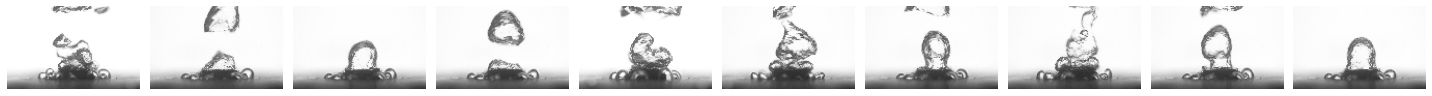

(64, 80, 128, 3)

In [7]:
images,labels = next(train_generator)
imageplot(images)
images.shape

# Importing pre-trained model

In [8]:
from tensorflow.keras.applications import vgg16
vgg16_model = vgg16.VGG16()

In [9]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

for layer in model.layers:
    layer.trainable = False
    
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# Building my own model

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(80, 128, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
# compile model
#opt = SGD(lr=0.001, momentum=0.9)

# Defining the model callbacks

In [14]:
#from keras.utils.vis_utils import plot_model
#plot_model(model,to_file='/jet/home/mhrahman/Projects/HW1/Figures/model_cnn.png',show_shapes=True, show_layer_names=True)

In [11]:
class TimeCallback(Callback):
    def on_train_begin(self,logs={}):
        self.logs=[]
    def on_epoch_begin(self,epoch,logs={}):
        self.starttime = time()
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(time()-self.starttime)
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience = 20,min_delta = 1)
cb = TimeCallback()
checkpoints = ModelCheckpoint('weight_03.hdf5',monitor='accuracy',verbose=1,save_best_only= True,mode='max')

# Model compilation

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
with open('modelsummary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 128, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 20480)            

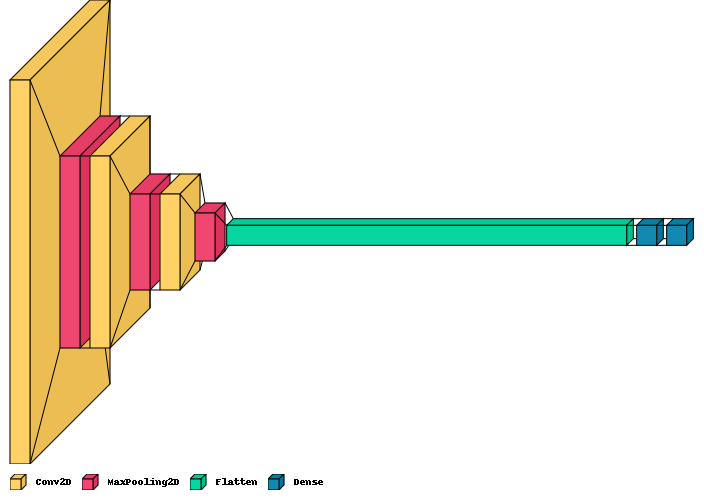

In [13]:
visualkeras.layered_view(model,legend = True,scale_xy=3,to_file='output.png')

# Model fitting

In [ ]:
model_history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator),
validation_data=val_generator, validation_steps=len(val_generator), epochs=20, verbose=1, callbacks = [es,cb,checkpoints])

157/224 [====================>.........] - ETA: 3:05 - loss: 0.3141 - accuracy: 0.9072

# Plot the results

In [1]:
#plot training and validation curve
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r')
plt.plot(epochs,val_acc,'b')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.savefig('/jet/home/mhrahman/Projects/HW2/Figures/Classification_acc.jpg',dpi = 300)
plt.show()


plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(["Training loss","Validation loss"])
plt.savefig('/jet/home/mhrahman/Projects/HW2/Figures/Classification_loss.jpg',dpi = 300)
plt.show()

NameError: name 'model_history' is not defined

In [ ]:
plt.plot(cb.logs)
plt.title('Time per epoch')
plt.xlabel('Epoch')
plt.ylabel('Time')
plt.legend(['Time'],loc = 'upper right')
#path = r'/jet/home/mhrahman/Projects/HW1/Figures/Classification_loss.jpg'
plt.savefig(r'/jet/home/mhrahman/Projects/HW2/Figures/Time.jpg', dpi = 300)

In [ ]:
Y_pred = model.predict(test_generator)

In [40]:
def plot_confusion_matrix(cm,classes,normalize = False,title = 'Confusion matrix',cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astyle('float')/cm.sum(axis = 1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normazlization')
    print(cm)
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation = 45)
    plt.yticks(tick_marks,classes)
    threshold = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment = 'center',
                color = "red" if cm[i,j]> threshold else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [1]:
Y_pred_label = np.where(Y_pred > 0.5,1,0)
#Y_pred_label = model.predict_classes(test_generator)
cm = confusion_matrix(test_generator.classes,Y_pred_label)
cm_plot_labels = ['Pre','Post']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels)
plt.savefig('/jet/home/mhrahman/Projects/HW2/Figures/Classification_conf_mat.jpg', dpi = 300)
plt.show()

NameError: name 'np' is not defined

In [48]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve,roc_auc_score
accuray = accuracy_score(test_generator.classes,Y_pred_label)
precision = precision_score(test_generator.classes,Y_pred_label)
recall = recall_score(test_generator.classes,Y_pred_label)
F1 = f1_score(test_generator.classes,Y_pred_label)
print('Accuracy: {}'.format(accuray))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1_score: {}'.format(F1))

Accuracy: 0.4880803011292346
Precision: 0.4782608695652174
Recall: 0.4782608695652174
F1_score: 0.4782608695652174


In [44]:
auc_score = roc_auc_score(test_generator.classes,Y_pred)
fpr,tpr,_ = roc_curve(test_generator.classes,Y_pred)
print(auc_score)

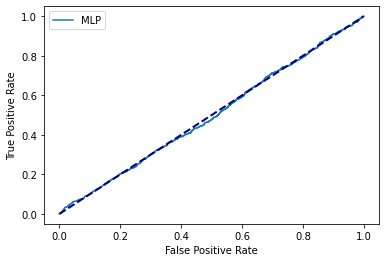

In [50]:
plt.plot(fpr,tpr,linestyle = '-',label = 'CNN')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/jet/home/mhrahman/Projects/HW2/Figures/Roc_curve.jpg',dpi = 300)
plt.show()

# Feature map extraction

In [10]:
model2 = tf.keras.models.load_model(r'/jet/home/mhrahman/Projects/HW2/codes/weight_03.hdf5')

In [12]:
model2 = tf.keras.models.Model(inputs = model2.input,outputs = model2.layers[1].output)
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 80, 128, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 128, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 64, 32)        0         
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


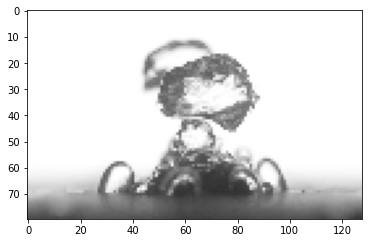

In [43]:
images,labels = next(train_generator)
plt.imshow(images[0])
plt.savefig('/jet/home/mhrahman/Projects/HW2/Figures/main_image.jpg',dpi = 300)

In [44]:
img = np.expand_dims(images[0],axis=0)
img /= 255
feature_map = model2.predict(img)

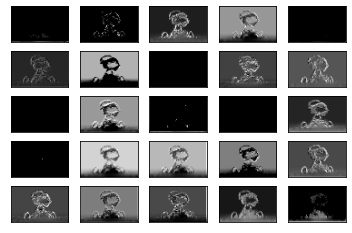

In [46]:
square = 5
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_map[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.savefig('/jet/home/mhrahman/Projects/HW2/Figures/Feature_map.jpg',dpi = 300)
plt.show()